# **PREDICTION OF VIDEO GAME'S COMMERCIAL SUCCESS USING PYSPARK**

The video game industry is dynamic and competitive, with numerous factors influencing the success of a game in the market. This project aims to leverage PySpark, a powerful big data processing framework, to analyze various aspects of video game commercial success and sales strategy.


#### **Team 07 :** *Nishok Ilangovan* | *Sandeepkumar Vijaya Kumar* | *Rohit Ananthan*

# **Importance of PySpark in our project**

Imagine PySpark as the ultimate power-up in our video game adventure! Just like a legendary item that boosts your character's abilities to epic proportions, PySpark turbocharges our project with unrivaled speed and efficiency. With PySpark's Python API as our trusty controller, we're not just players – we're masters of the game, wielding the power of distributed computing to conquer colossal datasets like heroic adventurers on a quest for treasure.


As we journey through the digital realm of video game analytics, PySpark equips us with legendary weapons like machine learning algorithms and clustering techniques, enabling us to uncover hidden insights and unlock the secrets of commercial success.

## **Expected Outcome:**

- Predictive models for commercial success prediction with high accuracy and interpretability.
- Insights into frequent patterns in video game sales data to inform targeted marketing campaigns and bundle offerings.
- Optimized inventory management strategies based on clusters of video games with similar characteristics.
- Understanding of relationships between video games, facilitating personalized recommendations and cross-promotion strategies.

In [1]:
! pip install pyspark

In [2]:
from pyspark.sql import SparkSession
session= SparkSession.builder.appName("videogames").getOrCreate()

In [3]:
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import *

import pandas as pd

# **Dataset of Interest**

## Steam Website Overview
Steam is a digital distribution platform developed by Valve Corporation, primarily for purchasing and playing video games. Launched in 2003, it offers a vast library of games across various genres for Windows, macOS, and Linux platforms. In addition to games, Steam provides features such as game updates, community forums, social networking, and digital rights management.

Steam emerges as a preferred platform for collecting game information due to several compelling reasons. Firstly, Steam stands as one of the largest and most popular digital distribution platforms for video games, boasting a vast and diverse library of titles spanning various genres and platforms. This extensive catalog provides researchers with access to a rich dataset encompassing a wide range of game characteristics, player engagement metrics, and success indicators.

## Dataset Information
The "steam_data_set" obtained from Steam via Kaggle is a dataset containing comprehensive information about games available on the Steam platform. It encompasses a wide range of attributes for each game, allowing for detailed analysis and exploration of various aspects such as game characteristics, player engagement, and success metrics.


https://www.kaggle.com/datasets/nikdavis/steam-store-games


## Columns Information

- **appid** (integer): *Unique identifier for each game on Steam.*
- **name** (string): *Title of the game.*
- **release_date** (date): *Date when the game was released.*
- **english** (boolean): *Indicates whether the game supports the English language.*
- **developer** (string): *Company or individual responsible for developing the game.*
- **publisher** (string): *Company responsible for publishing and distributing the game.*
- **platforms** (string): *Platforms on which the game is available (e.g., Windows, macOS, Linux).*
- **required_age** (integer): *Age rating or recommended age for playing the game.*
- **categories** (string): *Categories or classifications of the game.*
- **genres** (string): *Genres of the game (e.g., action, adventure, RPG).*
- **steamspy_tags** (string): *Tags associated with the game on Steam Spy.*
- **achievements** (integer): *Number of achievements available in the game.*
- **positive_ratings** (integer): *Number of positive ratings/reviews received by the game.*
- **negative_ratings** (integer): *Number of negative ratings/reviews received by the game.*
- **average_playtime** (integer): *Average playtime of the game in minutes.*
- **median_playtime** (integer): *Median playtime of the game in minutes.*
- **owners** (string): *Range of estimated owners of the game.*
- **price** (float): *Price of the game in USD.*
- **success** (boolean): *Indicates whether the game can be considered successful.*


These columns provide detailed insights into various aspects of each game, including its characteristics, player feedback, playtime statistics, ownership, pricing, and success metrics.


In [4]:
video_games_data = session.read.csv('Games_Dataset_Final.csv', header=True, inferSchema=True)

In [5]:
video_games_data.show(5)
print("Number of observations:",video_games_data.count())
print("Information of columns:\n",video_games_data.columns)

+-----+--------------------+------------+-------+----------------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+-----------------+-----+-------+
|appid|                name|release_date|english|       developer|publisher|        platforms|required_age|          categories|genres|       steamspy_tags|achievements|positive_ratings|negative_ratings|average_playtime|median_playtime|           owners|price|success|
+-----+--------------------+------------+-------+----------------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+-----------------+-----+-------+
|   10|      Counter-Strike|  01-11-2000|      1|           Valve|    Valve|windows;mac;linux|           0|Multi-player;Onli...|Action|Action;FPS;Multip...|           0|          124534|       

## **Exploratory Data Analysis**

In initial exploratory data analysis (EDA) of the game dataset, summary statistics provide valuable insights into the distribution and characteristics of each column, helping to identify patterns, outliers, and potential challenges that may impact model creation.

In [6]:
print("Description of columns:\n",video_games_data.describe().show(3))

+-------+------------------+--------+------------+-------------------+-----------------+-----------------+---------+------------------+----------+------+-------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------+
|summary|             appid|    name|release_date|            english|        developer|        publisher|platforms|      required_age|categories|genres|steamspy_tags|      achievements|  positive_ratings|  negative_ratings|  average_playtime|   median_playtime|           owners|            price|success|
+-------+------------------+--------+------------+-------------------+-----------------+-----------------+---------+------------------+----------+------+-------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------+
|  count|             27075|   27075|       27075|              27075|         

# **Feature Engineering**

In this project, feature engineering is crucial because it allows us to tailor the model to the specific nuances of our dataset. By carefully crafting features, we can highlight relevant information and reduce noise, ultimately improving the model's ability to extract meaningful patterns and make accurate predictions. Additionally, feature engineering enables us to incorporate domain knowledge and insights, empowering the model to better capture the intricacies of the problem we're solving. Some of the feature engineering we plan to incorporate are

- Data Cleaning
- String Indexing
- One Hot encoding
- Min Max Scaling
- Vector Assembler


## Data Cleaning

In our dataset, we aim to remove the null values that can impair the model's opertaion or performance. This is approached by searchung for null values across all columns and removing the na observations

In [7]:
na_counts = video_games_data.select([col(c).isNull().cast("int").alias(c) for c in video_games_data.columns]).agg(*[sum(col(c)).alias(c) for c in video_games_data.columns])
na_counts.show()

+-----+----+------------+-------+---------+---------+---------+------------+----------+------+-------------+------------+----------------+----------------+----------------+---------------+------+-----+-------+
|appid|name|release_date|english|developer|publisher|platforms|required_age|categories|genres|steamspy_tags|achievements|positive_ratings|negative_ratings|average_playtime|median_playtime|owners|price|success|
+-----+----+------------+-------+---------+---------+---------+------------+----------+------+-------------+------------+----------------+----------------+----------------+---------------+------+-----+-------+
|    0|   0|           0|      0|        0|        0|        0|           0|         0|     0|            0|           0|               0|               0|               0|              0|     0|    0|      0|
+-----+----+------------+-------+---------+---------+---------+------------+----------+------+-------------+------------+----------------+----------------+-----

### Average Number of users (owner)

The dataset had ranges of values of number of users playingthe game. We decided to take the average out of them to come up with mean number of active users and storing it in a column.

In [8]:
video_games_data = video_games_data.withColumn("owners_start", split(col("owners"), "-").getItem(0).cast("double"))
video_games_data = video_games_data.withColumn("owners_end", split(col("owners"), "-").getItem(1).cast("double"))

# Calculate the average of the range
video_games_data = video_games_data.withColumn("average_owners", (col("owners_start") + col("owners_end")) / 2)

# Replace the original values with the average
video_games_data = video_games_data.withColumn("owners", expr("cast(average_owners as string)"))

# Drop intermediate columns if needed
video_games_data = video_games_data.drop("owners_start", "owners_end")

### Release Date

The release date of each games was processed to obtain the decade of the games, which had an impact of users playing a game. We beleive that theearlier decades, people were more interested in buying games, but now since there are lot of entertainment options , this decade may be facing a dull performance in games unless it is a big title.

In [9]:
video_games_data = video_games_data.withColumn("release_date", to_date("release_date", "dd-MM-yyyy"))

# Extract decade from release_date
video_games_data = video_games_data.withColumn("decade", floor(year("release_date") / 10) * 10)
video_games_data.show(2)

+-----+--------------------+------------+-------+---------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+
|appid|                name|release_date|english|developer|publisher|        platforms|required_age|          categories|genres|       steamspy_tags|achievements|positive_ratings|negative_ratings|average_playtime|median_playtime|   owners|price|success|average_owners|decade|
+-----+--------------------+------------+-------+---------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+
|   10|      Counter-Strike|  2000-11-01|      1|    Valve|    Valve|windows;mac;linux|           0|Multi-player;Onli...|Action|Action;FPS;Multip...|           0|          

### Casting Datatypes of Features

Converting or Casting the datatypes of certain features to make it compatible with other features in the model.

In [10]:
video_games_data = video_games_data.selectExpr("*", "CAST(positive_ratings AS INT) AS positive_ratings_int", "CAST(achievements AS INT) AS achievments_int", "CAST(price AS INT) AS price_int", "CAST(english AS INT) AS english_int")
video_games_data = video_games_data.dropna()

### Dummy Variables for One Hot Encoding

In the context of feature engineering for a project involving game success prediction, the challenge arises when dealing with categorical data stored as delimited strings in a single column, such as "action;adventure;music." While traditional methods like one-hot encoding are readily available in tools like R, PySpark lacks a built-in equivalent, necessitating a custom solution.

To address this, a custom method is created to transform the categorical data into dummy variables suitable for machine learning models. This method parses the delimited strings, splitting them into individual categories and creating binary columns for each unique category. For instance, the original column "genres" with values "action;adventure;music" would be transformed into separate columns for "action," "adventure," and "music," with binary indicators representing the presence or absence of each genre for each observation.

We will proceed this for teh following variables

- Platforms
- Categories
- Genres

In [11]:
split_df = video_games_data.withColumn("platforms", split(video_games_data["platforms"], ";"))

# Get unique platforms
unique_platforms = set()
for row in split_df.collect():
    unique_platforms.update(row["platforms"])

# Iterate over each platform and create columns
for platform in unique_platforms:
    # Create column name
    col_name = "platform_" + platform

    # Check if platform exists in the list for each row
    video_games_data = video_games_data.withColumn(col_name,
                       when(video_games_data["platforms"].contains(platform), 1).otherwise(0))

# Show the result
video_games_data = video_games_data.drop('platform_ ""Adiart"""','platform_Nostatic Software, LLC')
video_games_data.show(3)

+-----+--------------------+------------+-------+---------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+--------------------+---------------+---------+-----------+----------------+--------------+------------+
|appid|                name|release_date|english|developer|publisher|        platforms|required_age|          categories|genres|       steamspy_tags|achievements|positive_ratings|negative_ratings|average_playtime|median_playtime|   owners|price|success|average_owners|decade|positive_ratings_int|achievments_int|price_int|english_int|platform_windows|platform_linux|platform_mac|
+-----+--------------------+------------+-------+---------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+---------+-

In [12]:
split_df = video_games_data.withColumn("genres", split(video_games_data["genres"], ";"))

# Get unique platforms
unique_genres = set()
for row in split_df.collect():
    unique_genres.update(row["genres"])

# Iterate over each platform and create columns
for genre in unique_genres:
    # Create column name
    col_name = "genre_" + genre

    # Check if platform exists in the list for each row
    video_games_data = video_games_data.withColumn(col_name,
                       when(video_games_data["genres"].contains(genre), 1).otherwise(0))

# Show the result
video_games_data.show(3)

+-----+--------------------+------------+-------+---------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+--------------------+---------------+---------+-----------+----------------+--------------+------------+---------------+---------------------------+------------+----------------+----------------------+----------+----------------------+-------------+------------------+------------+---------------+--------------------+------------+--------------+------------+-----------------+---------+-------------------+---------------+------------------+-----------------------+-----------+--------------+--------------------------+----------------------+---------------------------+--------------------+----------------+------------+
|appid|                name|release_date|english|developer|publisher|        platforms|required_age|  

In [13]:
split_df = video_games_data.withColumn("categories", split(video_games_data["categories"], ";"))

# Get unique categories
unique_categories = set()
for row in split_df.collect():
    unique_categories.update(row["categories"])

for category in unique_categories:
    # Create column name
    col_name = "category_" + category

    # Check if categories exists in the list for each row
    video_games_data = video_games_data.withColumn(col_name,
                       when(video_games_data["categories"].contains(category), 1).otherwise(0))
# Show the result
video_games_data.show(2)

+-----+--------------------+------------+-------+---------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+--------------------+---------------+---------+-----------+----------------+--------------+------------+---------------+---------------------------+------------+----------------+----------------------+----------+----------------------+-------------+------------------+------------+---------------+--------------------+------------+--------------+------------+-----------------+---------+-------------------+---------------+------------------+-----------------------+-----------+--------------+--------------------------+----------------------+---------------------------+--------------------+----------------+------------+-----------------------------+----------------------+---------------------+----------------------------

 # String Indexing

In our project, string indexing is being utilized as a crucial component of feature engineering to bolster the predictive capabilities of our machine learning model. This involves converting categorical variables like 'success,' 'decade,' 'developer,' and 'publisher' into numerical representations, enabling more effective analysis and pattern recognition. String indexing standardizes the encoding of categorical variables, ensuring consistency and compatibility across the machine learning pipeline. Additionally, by employing 'handleInvalid="keep,"' we ensure the model can handle unforeseen or irregular categories during deployment, preserving dataset integrity. Overall, the incorporation of string indexing aligns with our goal of developing a robust and accurate predictive model for game success prediction.


In [14]:
str_idx=StringIndexer(inputCols=['success','decade','developer','publisher'], outputCols=['Newsuccess','Newdecade','Newdeveloper','Newpublisher'], stringOrderType='alphabetAsc', handleInvalid="keep")

# One Hot Encoding

In our project, we're implementing one-hot encoding as part of feature engineering to enhance the effectiveness of our machine learning model. This process involves converting categorical variables represented by numerical indices, such as 'Newdecade,' 'Newdeveloper,' and 'Newpublisher,' into binary vectors, creating new columns like 'Finaldecade,' 'Finaldeveloper,' and 'Finalpublisher.'

By utilizing the OneHotEncoder, we standardize this transformation, ensuring consistency and compatibility within our machine learning pipeline. This approach enables the model to effectively interpret categorical variables and uncover valuable insights from the data.

Ultimately, the integration of one-hot encoding aligns with our overarching objective of developing a robust and precise predictive model for game success prediction.

In [15]:
onehot=OneHotEncoder(inputCols=['Newdecade','Newdeveloper','Newpublisher'], outputCols=['Finaldecade','Finaldeveloper','finalpublisher'])

# Vector Assembler

 we're utilizing the VectorAssembler as a crucial step in feature engineering to consolidate multiple input columns into a single feature vector. This involves combining numerical features such as "achievements_int," "price_int," "positive_ratings_int," "negative_ratings," "average_playtime," "median_playtime," and "average_owners" into a unified vector representation named "ach_price_ratings_playtime_owners."

By employing the VectorAssembler, we streamline this process, creating a cohesive feature vector that encapsulates the relevant information from each input column. This unified representation facilitates efficient data processing and analysis within our machine learning pipeline.

Ultimately, the use of VectorAssembler aligns with our objective of optimizing feature representation and enhancing the predictive capabilities of our machine learning model for game success prediction.

In [16]:
va = VectorAssembler(inputCols=["achievments_int","price_int","positive_ratings_int","negative_ratings","average_playtime","median_playtime","average_owners"], outputCol="ach_price_ratings_playtime_owners")


# Min-Max Scaling

In our project, we're integrating the MinMaxScaler as a pivotal component of feature preprocessing to scale numerical features within a specific range. This involves applying the MinMaxScaler to the feature vector "ach_price_ratings_playtime_owners," generated by the VectorAssembler, and transforming it into a new feature vector named "ach_price_ratings_playtime_owners_mm_scaled."

By incorporating the MinMaxScaler, we standardize the scaling of numerical features, ensuring they fall within a predefined range, typically between 0 and 1. This normalization process preserves the relative relationships between features while mitigating the impact of outliers.

In [17]:
mm = MinMaxScaler(inputCol="ach_price_ratings_playtime_owners", outputCol="ach_price_ratings_playtime_owners_mm_scaled")

In [18]:
va1=VectorAssembler(inputCols=['ach_price_ratings_playtime_owners_mm_scaled','platform_windows', 'platform_linux', 'platform_mac', 'genre_Gore', 'genre_Casual', 'genre_Video Production', 'genre_Photo Editing', 'genre_Massively Multiplayer', 'genre_Adventure', 'genre_Sports', 'genre_Tutorial', 'genre_Simulation', 'genre_Software Training', 'genre_Documentary', 'genre_Game Development', 'genre_Accounting', 'genre_Animation & Modeling', 'genre_RPG', 'genre_Audio Production', 'genre_Racing', 'genre_Design & Illustration', 'genre_Strategy', 'genre_Early Access', 'genre_Utilities', 'genre_Nudity', 'genre_Web Publishing', 'genre_Action', 'genre_Indie', 'genre_Sexual Content', 'genre_Violent', 'genre_Education', 'genre_Free to Play'], outputCol="all_features")

In [19]:
# function for calculating accuracy
def calculate_accuracy(model):
  model_acc = model.select('Newsuccess','prediction').toPandas()
  model_correct_counts = model_acc[(model_acc["Newsuccess"] == model_acc["prediction"])].sum()
  return (model_correct_counts/model_acc.count())

# Classification Modelling

Classification modeling analyzes game features to predict success and optimize marketing, aiding decision-making in game development and marketing strategies. By examining historical data on successful games, classification models can identify patterns and factors contributing to success. This enables developers and publishers to make data-driven decisions about which game concepts to pursue, reducing the risk of investing in projects with uncertain outcomes.






# Random Forest Classifier

Random Forest is selected for its robustness against overfitting, high predictive accuracy, and inherent feature importance assessment, making it ideal for complex tasks like game success prediction. Using a Random Forest Classifier with PySpark offers scalability and parallel processing for handling large game datasets efficiently. PySpark's integrated ecosystem streamlines end-to-end data processing, feature engineering, and model deployment.


In [20]:
forest = RandomForestClassifier(featuresCol='ach_price_ratings_playtime_owners_mm_scaled', labelCol="Newsuccess")
forestpipeline=Pipeline(stages=[str_idx,onehot,va,mm,forest])

training, test=video_games_data.randomSplit([0.8,0.2], seed=100)
forestmodel=forestpipeline.fit(training)
forestresults=forestmodel.transform(test)

forestresults.show(2, truncate=False)

+-----+----------------------+------------+-------+---------+---------+-----------------+------------+-------------------------------------------------------------------------------------------------------------------------+------+----------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+--------------------+---------------+---------+-----------+----------------+--------------+------------+---------------+---------------------------+------------+----------------+----------------------+----------+----------------------+-------------+------------------+------------+---------------+--------------------+------------+--------------+------------+-----------------+---------+-------------------+---------------+------------------+-----------------------+-----------+--------------+--------------------------+----------------------+---------------------------+--------------------+----------------+-----------

# Logistic Regression

The logistic regression model is chosen for its simplicity, interpretability, and effectiveness in binary classification tasks like game success prediction. Utilizing the LogisticRegression model with PySpark offers scalability and parallel processing capabilities, enabling efficient handling of large game datasets.

In [21]:
lr = LogisticRegression(featuresCol='all_features', labelCol="Newsuccess")
lrpipeline=Pipeline(stages=[str_idx,onehot,va,mm,va1,lr])

training, test=video_games_data.randomSplit([0.8,0.2], seed=100)
lrmodel=lrpipeline.fit(training)
lrresults=lrmodel.transform(test)

lrresults.show(2, truncate=False)

+-----+----------------------+------------+-------+---------+---------+-----------------+------------+-------------------------------------------------------------------------------------------------------------------------+------+----------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+--------------------+---------------+---------+-----------+----------------+--------------+------------+---------------+---------------------------+------------+----------------+----------------------+----------+----------------------+-------------+------------------+------------+---------------+--------------------+------------+--------------+------------+-----------------+---------+-------------------+---------------+------------------+-----------------------+-----------+--------------+--------------------------+----------------------+---------------------------+--------------------+----------------+-----------

# Area Under ROC for Models

In [22]:
foresteval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="Newsuccess")
foresteval.evaluate(forestresults)

0.7824612403100775

In [23]:
lreval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="Newsuccess")
lreval.evaluate(lrresults)

0.8156619921578615

Area Under the ROC Curve (AUC) measures the ability of a binary classification model to distinguish between positive and negative classes. A higher AUC value indicates better model performance in correctly identifying positive instances.

The Random Forest model has an AUC of 0.72, while the Logistic Regression model achieves a higher AUC of 0.82. This difference suggests that the Logistic Regression model outperforms the Random Forest model in distinguishing between positive and negative instances, indicating superior predictive capability and potential for better performance in game success prediction tasks.

# Accuracies of the Models

In [24]:
calculate_accuracy(lrresults)

Newsuccess    0.80591
prediction    0.80591
dtype: float64

In [25]:
calculate_accuracy(forestresults)

Newsuccess    0.809418
prediction    0.809418
dtype: float64

The accuracy of the Logistic Regression model is approximately 80.59%, while the accuracy of the Random Forest model is around 80.94%. Both models demonstrate relatively similar accuracies, indicating comparable performance in correctly predicting game success.

# **Future Scope**

Both the Logistic Regression and Random Forest models can be leveraged for predicting game success and informing future business decisions in the gaming industry.

**Prediction of Game Success:** These models utilize various features such as genre, developer, publisher, price, and user ratings to predict the likelihood of a game's success. By inputting data on upcoming or planned game releases into the trained models, businesses can obtain predictions on the potential success of these games. This aids in prioritizing resource allocation, marketing efforts, and strategic planning.

**Targeted Marketing:** The models' predictions can guide targeted marketing campaigns by identifying key factors influencing game success. For instance, if the models highlight positive user ratings and lower price as significant predictors of success, marketing strategies can emphasize these aspects to attract potential buyers.

**Product Development:** Insights from the models can inform product development decisions. For example, if certain genres consistently perform well according to the models, game developers may focus on creating more titles in those genres to capitalize on market demand.



Overall, integrating the predictive insights from these models into business strategies enables companies to make data-driven decisions, optimize resource allocation, and enhance sales performance in the competitive gaming market.

# Frequent Pattern Mining

Frequent Pattern Mining (FPM) is a technique used to discover recurring patterns or itemsets in a dataset. In the context of video game data, FPM can analyze tags associated with games to identify frequently occurring combinations of tags.

Business Problems we are trying to solve:

- Increasing Revenue Through Bundled Game Sales
- Enhancing Customer Segmentation for Targeted Marketing



In [26]:
video_games_data = video_games_data.withColumn('tags_array', split(video_games_data['steamspy_tags'], ';'))
video_games_data.select('tags_array').show(2)

+--------------------+
|          tags_array|
+--------------------+
|[Action, FPS, Mul...|
|[Action, FPS, Mul...|
+--------------------+
only showing top 2 rows



Using frequent pattern mining on the **'steamtag_pys'** tag data can provide useful insights for the given business questions. By analyzing patterns of tag co-occurrence, FPM helps identify popular tag combinations and understand customer preferences. This information can be valuable for creating bundled game sales packages that appeal to a wide audience and for refining customer segmentation strategies for targeted marketing efforts. Overall, FPM offers a data-driven approach to uncovering patterns in customer behavior and preferences, which can inform strategic decision-making in the gaming industry.

In [27]:
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol="tags_array", minSupport=0.0, minConfidence=0.0)

model = fpGrowth.fit(video_games_data)

tags = model.freqItemsets

print("Number of observations in new data set:",tags.count())
print(tags.show(10,truncate=False))

Number of observations in new data set: 7771
+----------------------------------+----+
|items                             |freq|
+----------------------------------+----+
|[Tanks]                           |21  |
|[Tanks, Multiplayer]              |3   |
|[Tanks, Multiplayer, Free to Play]|1   |
|[Tanks, Multiplayer, Action]      |1   |
|[Tanks, Multiplayer, Early Access]|1   |
|[Tanks, Free to Play]             |5   |
|[Tanks, Free to Play, Action]     |4   |
|[Tanks, Simulation]               |6   |
|[Tanks, Simulation, Strategy]     |2   |
|[Tanks, Simulation, Action]       |1   |
+----------------------------------+----+
only showing top 10 rows

None


## Association Rules

Association rules derived from frequent pattern mining can inform product bundling, targeted marketing, and customer segmentation in the gaming industry. By identifying patterns of co-occurrence between game tags or features, businesses can create bundled game sales packages tailored to customer preferences, target marketing efforts to specific audience segments, and refine customer segmentation strategies based on shared interests.

In [28]:
rules=model.associationRules
rules.show(3)

+--------------------+----------------+----------+------------------+--------------------+
|          antecedent|      consequent|confidence|              lift|             support|
+--------------------+----------------+----------+------------------+--------------------+
|[Walking Simulato...|     [Adventure]|       1.0| 3.484747071695199|3.693716987404425E-5|
|     [Funny, Puzzle]|[Pixel Graphics]|       0.5|54.363453815261046|3.693716987404425E-5|
|     [Funny, Puzzle]|        [Action]|       0.5|1.3114222049990312|3.693716987404425E-5|
+--------------------+----------------+----------+------------------+--------------------+
only showing top 3 rows



EDA of the performance metrics in the association rules.

In [29]:
rules.summary().show(3)

+-------+-------------------+------------------+--------------------+
|summary|         confidence|              lift|             support|
+-------+-------------------+------------------+--------------------+
|  count|              18851|             18851|               18851|
|   mean| 0.2164544490700606| 51.92053481293637|4.387021258611625...|
| stddev|0.31603358149528665|453.23174465464405|0.004591310135544972|
+-------+-------------------+------------------+--------------------+
only showing top 3 rows



In the EDA, we are aiming the final quadrant that is 75% for our following business problems ensuring the capture of top performing games.

# Business Problems
1. Increasing Revenue Through Bundled Game Sales
2. Enhancing Customer Segmentation for Targeted Marketing

# 1. Increasing Revenue Through Bundled Game Sales

 Utilize lift and support metrics to identify pairs or groups of game tags that have both a high lift (indicating strong association) and high support (indicating popularity). These combinations can be used to create bundled game packages or themed collections that appeal to a wide audience while leveraging the cross-selling potential between associated tags. By offering these bundles at a discounted price or as part of a limited-time promotion, you can encourage customers to purchase multiple games together, leading to increased revenue.


In [30]:
result1=rules.filter((rules['lift']>10) & (rules['confidence']>0.28))
result1.show(5)
result1.select('antecedent').limit(5).rdd.flatMap(lambda x: x).collect()

+--------------------+--------------------+------------------+------------------+--------------------+
|          antecedent|          consequent|        confidence|              lift|             support|
+--------------------+--------------------+------------------+------------------+--------------------+
|     [Funny, Puzzle]|    [Pixel Graphics]|               0.5|54.363453815261046|3.693716987404425E-5|
|[Resource Managem...|      [City Builder]|               0.5| 190.6549295774648| 7.38743397480885E-5|
|[Action-Adventure...|           [Zombies]|0.3333333333333333| 57.11603375527426|3.693716987404425E-5|
|[Audio Production...|         [Utilities]|               1.0|196.18115942028987|3.693716987404425E-5|
|[Parkour, Platfor...|[Female Protagonist]|               1.0|136.04522613065328|3.693716987404425E-5|
+--------------------+--------------------+------------------+------------------+--------------------+
only showing top 5 rows



[['Funny', 'Puzzle'],
 ['Resource Management', 'Strategy'],
 ['Action-Adventure', 'Adventure'],
 ['Audio Production', 'Animation & Modeling'],
 ['Parkour', 'Platformer']]

***Inference***

The identified pairs of game tags, such as **'Funny' and 'Puzzle'**, **'Resource Management' and 'Strategy'**, indicate strong associations between these tags. This suggests that customers who are interested in one tag are likely to be interested in the other as well. By bundling games with these associated tags together, you can create appealing packages that cater to a broader audience. For example, offering a bundle containing both funny and puzzle games would attract customers who enjoy both genres, potentially leading to increased sales as customers are incentivized to purchase multiple games together. Additionally, leveraging the cross-selling potential of associated tags can help maximize revenue by encouraging customers to explore and purchase additional games within the bundle.

# 2. Enhancing Customer Segmentation for Targeted Marketing

Utilize support and confidence metrics to refine customer segmentation strategies based on game tag preferences. Calculate support values to identify popular game tags among different customer segments, indicating the overall popularity of each tag within a segment. Then, use confidence values to measure the strength of associations between specific game tags and customer segments. High-confidence rules indicate that certain tags are strongly associated with particular segments, suggesting targeted marketing opportunities. By leveraging both support and confidence metrics, you can refine customer segmentation criteria and tailor marketing campaigns to specific segments based on their preferences, leading to more effective targeting and higher conversion rates.

In [31]:
result2=rules.filter((rules['support']>0.05) & (rules['confidence']>0.05))
result2.orderBy("confidence",ascending=False).show(3)
result2.select('antecedent').limit(5).rdd.flatMap(lambda x: x).collect()

+----------------+----------+------------------+------------------+--------------------+
|      antecedent|consequent|        confidence|              lift|             support|
+----------------+----------+------------------+------------------+--------------------+
|[Casual, Action]|   [Indie]|0.7256637168141593|1.2104678869568537|0.054519262734089316|
|        [Casual]|   [Indie]|0.6827544180377818|1.1388915809942617|  0.2069220256343959|
|        [Action]|   [Indie]|0.6464832396822321|1.0783882161378355|  0.2464817345694973|
+----------------+----------+------------------+------------------+--------------------+
only showing top 3 rows



[['Action', 'Indie'],
 ['Action', 'Indie'],
 ['Adventure', 'Action'],
 ['Adventure', 'Indie'],
 ['Casual']]

***Inference***

The identified associations between game tags and customer segments, such as **'Action' and 'Indie', 'Adventure' and 'Indie',** provide valuable insights into the preferences of different customer segments. High-confidence rules indicate strong associations between specific game tags and customer segments, suggesting targeted marketing opportunities. For instance, if **'Action'** games have a high confidence level among the **'Indie'** segment, it implies that customers in this segment are more likely to be interested in **'Action'** games. By tailoring marketing campaigns to specific segments based on their preferences, such as promoting indie action games to indie game enthusiasts, businesses can enhance the effectiveness of their marketing efforts and improve customer engagement. This targeted approach increases the likelihood of conversion as customers are presented with products that align closely with their interests and preferences.

## Clustering Analysis for Games Dataset

In this section, we perform clustering analysis on the games dataset, focusing on the features 'positive_ratings_int,' 'achievements_int,' and 'price_int.' The goal is to uncover patterns and categorize games based on these key attributes.

In [32]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [33]:
video_games_data.printSchema()

root
 |-- appid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- english: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- platforms: string (nullable = true)
 |-- required_age: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- steamspy_tags: string (nullable = true)
 |-- achievements: string (nullable = true)
 |-- positive_ratings: string (nullable = true)
 |-- negative_ratings: integer (nullable = true)
 |-- average_playtime: integer (nullable = true)
 |-- median_playtime: integer (nullable = true)
 |-- owners: string (nullable = true)
 |-- price: string (nullable = true)
 |-- success: string (nullable = true)
 |-- average_owners: double (nullable = true)
 |-- decade: long (nullable = true)
 |-- positive_ratings_int: integer (nullable = true)
 |-- achievments_int: integer (nullable = true)
 |-- price_in

In [34]:
assembler1 =VectorAssembler(inputCols=['positive_ratings_int','achievments_int','price_int'], outputCol='all_features2')

video_games_data = assembler1.transform(video_games_data)
video_games_data.select('all_features2').show(5,truncate=False)

+------------------+
|all_features2     |
+------------------+
|[124534.0,0.0,7.0]|
|[3318.0,0.0,3.0]  |
|[3416.0,0.0,3.0]  |
|[1273.0,0.0,3.0]  |
|[5250.0,0.0,3.0]  |
+------------------+
only showing top 5 rows



In [35]:
scaler = StandardScaler(inputCol='all_features2', outputCol="all_features2_scaled", withStd=True, withMean=False)
scalerModel = scaler.fit(video_games_data)
final_data = scalerModel.transform(video_games_data)
final_data.select('all_features2_scaled').show(5)

+--------------------+
|all_features2_scaled|
+--------------------+
|[6.55807128906817...|
|[0.17472883338789...|
|[0.17988960061876...|
|[0.06703731311114...|
|[0.27646967308211...|
+--------------------+
only showing top 5 rows



### Determining Optimal Number of Clusters (K) using Silhouette Score

To find the optimal number of clusters, we employed the Elbow Method with the Silhouette Score as the metric. Here's a summary of the process:

1. We experimented with a range of K values (number of clusters).
2. For each K, we computed the silhouette score, which measures the quality of the clusters. The silhouette score ranges from -1 to 1, where a higher score indicates better-defined clusters.
3. Plotted the results and identified the "elbow" point where the silhouette score is maximized.

The optimal K, determined by the Elbow Method with the Silhouette Score, is crucial for achieving meaningful and interpretable clusters in our dataset.

In [36]:
silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='all_features2_scaled', metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='all_features2_scaled', k=i)
    model=kmeans.fit(final_data)
    predictions=model.transform(final_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.9997213118815678
Silhouette Score for k = 3 is 0.850649746790881
Silhouette Score for k = 4 is 0.8984446740847992
Silhouette Score for k = 5 is 0.7329814517779383
Silhouette Score for k = 6 is 0.83599443704281
Silhouette Score for k = 7 is 0.7572076432283475
Silhouette Score for k = 8 is 0.7276247676376528
Silhouette Score for k = 9 is 0.5659173676685996


Plotting

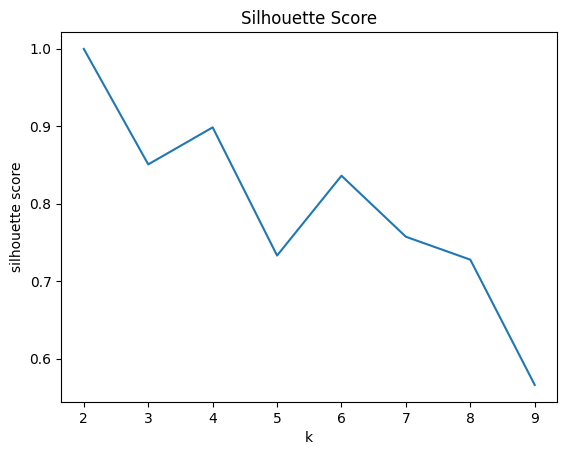

In [37]:
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [38]:
kmeans=KMeans(featuresCol="all_features2").setK(5).setSeed(123)
results=kmeans.fit(final_data).transform(final_data)
results.show(15)

+-----+--------------------+------------+-------+----------------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+---------+-----+-------+--------------+------+--------------------+---------------+---------+-----------+----------------+--------------+------------+---------------+---------------------------+------------+----------------+----------------------+----------+----------------------+-------------+------------------+------------+---------------+--------------------+------------+--------------+------------+-----------------+---------+-------------------+---------------+------------------+-----------------------+-----------+--------------+--------------------------+----------------------+---------------------------+--------------------+----------------+------------+-----------------------------+----------------------+---------------------+---------------------

In [39]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.01772468 0.05948394 0.16207438]
[16.74059959  0.43331672  1.35731191]
[5.26608901e-05 0.00000000e+00 4.64049862e+01]
[5.32822128e-03 1.34428426e+01 4.55583751e-01]
[9.52683376e-04 6.44410414e-03 1.85759789e+01]
[0.24245576 0.10378655 3.84728212]
[139.25666845   0.47351277   0.        ]
[0.08979812 0.06766872 1.64912326]
[0.02196106 0.04987782 0.75625302]


**Determining Cluster Centers**

Cluster centers, in the context of cluster analysis, refer to the central points within each cluster that represent the average or typical values of the features considered in the analysis. In video game clustering using features like Positive Rankings, Achievements, and Price, cluster centers can provide valuable insights into the characteristics of different groups of games.

## Clustering Analysis Results (k=4)

### Cluster 1: "Highly Rated, High Achievements, Premium Price"
Games in this cluster have received consistently high positive ratings, boast a significant number of achievements, and are priced at a premium level. These games may appeal to dedicated gamers who seek immersive experiences and are willing to invest in high-quality content.

### Cluster 2: "Moderate Ratings, Achievements, and Mid-range Price"
This cluster consists of games with moderate positive ratings, achievements, and fall within the mid-range price category. They offer a balanced gaming experience suitable for a broad audience, providing a mix of entertainment without being overly expensive.

### Cluster 3: "Positive Ratings, Few Achievements, Affordable"
Games in this cluster have positive ratings but fewer achievements compared to other clusters. They are priced affordably, making them attractive to budget-conscious gamers who still seek enjoyable gameplay experiences.

### Cluster 4: "Varied Ratings, High Achievements, Diverse Price Range"
This cluster includes games with varied positive ratings but a high number of achievements. The price range is diverse, indicating a mix of both premium and budget-friendly options. This cluster may appeal to gamers looking for diverse options based on achievements rather than relying solely on ratings.

In [40]:
cluster1=results.filter(results['prediction']==0)
cluster1.select('name').show(truncate=False)
cluster1.count()

+------------------------------+
|name                          |
+------------------------------+
|Team Fortress Classic         |
|Day of Defeat                 |
|Deathmatch Classic            |
|Half-Life: Opposing Force     |
|Ricochet                      |
|Half-Life                     |
|Counter-Strike: Condition Zero|
|Half-Life: Blue Shift         |
|Half-Life: Source             |
|Day of Defeat: Source         |
|Half-Life 2: Deathmatch       |
|Half-Life 2: Lost Coast       |
|Half-Life Deathmatch: Source  |
|Half-Life 2: Episode One      |
|Half-Life 2: Episode Two      |
|Left 4 Dead                   |
|Alien Swarm                   |
|Rag Doll Kung Fu              |
|Red Orchestra: Ostfront 41-45 |
|SiN Episodes: Emergence       |
+------------------------------+
only showing top 20 rows



26937

In [41]:
cluster2=results.filter(results['prediction']==1)
cluster2.select('name').show(truncate=False)
cluster2.count()

+--------------------------------+
|name                            |
+--------------------------------+
|Counter-Strike: Global Offensive|
+--------------------------------+



1

In [42]:
cluster3=results.filter(results['prediction']==2)
cluster3.select('name').show()
cluster3.count()

+--------------------+
|                name|
+--------------------+
|      Counter-Strike|
|         Half-Life 2|
|Counter-Strike: S...|
|              Portal|
|            Portal 2|
|       Killing Floor|
|        Just Cause 2|
|   BioShock Infinite|
|Sid Meier's Civil...|
|Call of Duty®: Mo...|
| Grand Theft Auto IV|
|The Witcher 2: As...|
|  Fallout: New Vegas|
|   PAYDAY™ The Heist|
|               LIMBO|
|Mount & Blade: Wa...|
|       Borderlands 2|
|            Mafia II|
|  Spec Ops: The Line|
|Saints Row: The T...|
+--------------------+
only showing top 20 rows



118

In [43]:
cluster4=results.filter(results['prediction']==3)
cluster4.select('name').show()
cluster4.count()

+--------------------+
|                name|
+--------------------+
|     Team Fortress 2|
|              Dota 2|
|PLAYERUNKNOWN'S B...|
+--------------------+



3

In [44]:
session.stop()